# Julia example: CriticalTransitions.jl

In [42]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Library/CloudStorage/OneDrive-UniversiteitUtrecht/Desktop/JuliaForLunch`


In [43]:
using DynamicalSystemsBase
using PyPlot

## Stommel box model

$$ \begin{align}
    \dot T &= - \frac{1}{\varepsilon} (T - T_0) - T - \mu T |T-S| \nonumber \\
    \dot S &= \sigma - S - \mu S|T-S|
\end{align}$$
with $\sigma = 0.9$, $\varepsilon=0.34$, $\mu=7.5$ and $T_0=1$.

In [44]:
function stommel(u, p, t)
    sigma, epsilon, mu, T0 = p
    T, S = u

    dT = -(T - T0)/epsilon - T - mu*T*abs(T - S)
    dS = sigma - S - mu*S*abs(T - S)

    return SVector{2}([dT, dS])
end

stommel (generic function with 1 method)

In [45]:
# Parameters
p = [0.9, 0.34, 7.5, 1] # [sigma, epsilon, mu, T0]

# Construct the system
stommel_ode = CoupledODEs(stommel, [1., 1.], p)

2-dimensional CoupledODEs
 deterministic: true
 discrete time: false
 in-place:      false
 dynamic rule:  stommel
 ODE solver:    Tsit5
 ODE kwargs:    (abstol = 1.0e-6, reltol = 1.0e-6)
 parameters:    [0.9, 0.34, 7.5, 1.0]
 time:          0.0
 state:         [1.0, 1.0]


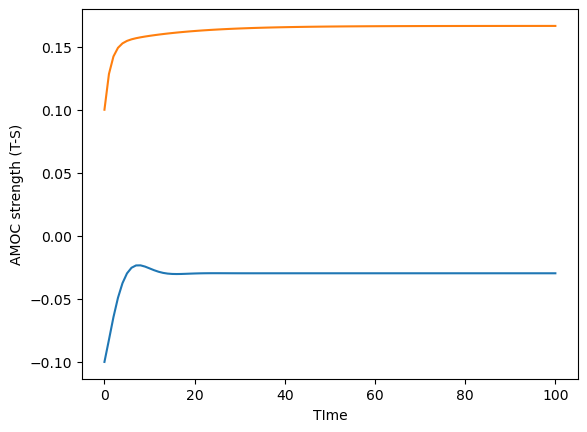

In [46]:
tr1 = trajectory(stommel_ode, 10, [0.7, 0.8]; Δt=0.1)
tr2 = trajectory(stommel_ode, 10, [0.5,0.4]; Δt=0.1)

fig, ax = subplots()
ax.plot(tr1[1][:,1] - tr1[1][:,2])
ax.plot(tr2[1][:,1] - tr2[1][:,2])
ax.set(xlabel="TIme", ylabel="AMOC strength (T-S)")

display(gcf())

In [47]:
A = tr1[1][end,:]
B = tr2[1][end,:]

println(A)
println(B)

[0.7063463257897112, 0.7360464761743751]
[0.5667455377033933, 0.4002885500815118]


## Install CriticalTransitions.jl

In [48]:
using CriticalTransitions
using StochasticDiffEq: EM

In [49]:
diffeq = (alg=EM(), dt=0.005)
stommel_sde = CoupledSDEs(stommel, [1.0, 1.0], p;
    noise_strength=0.05, diffeq)

2-dimensional CoupledSDEs
 deterministic: false
 discrete time: false
 in-place:      false
 dynamic rule:  stommel
 SDE solver:    EM
 SDE kwargs:    (dt = 0.005,)
 Noise type:    (additive = true, autonomous = true, linear = true, invertible = true)
 parameters:    [0.9, 0.34, 7.5, 1.0]
 time:          0.0
 state:         [1.0, 1.0]


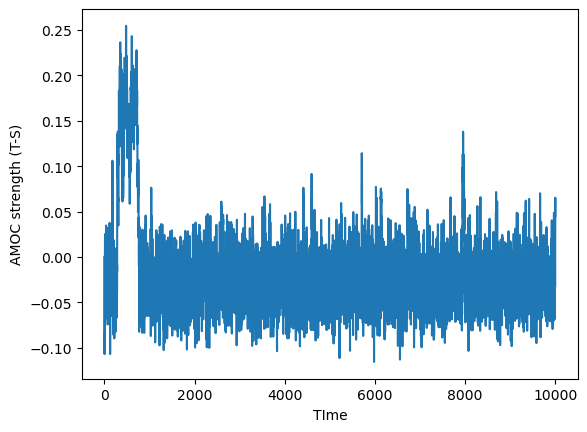

In [50]:
tr = trajectory(stommel_sde, 1000)

fig, ax = subplots()
ax.plot(tr[1][:,1] - tr[1][:,2])
ax.set(xlabel="TIme", ylabel="AMOC strength (T-S)")

display(gcf())

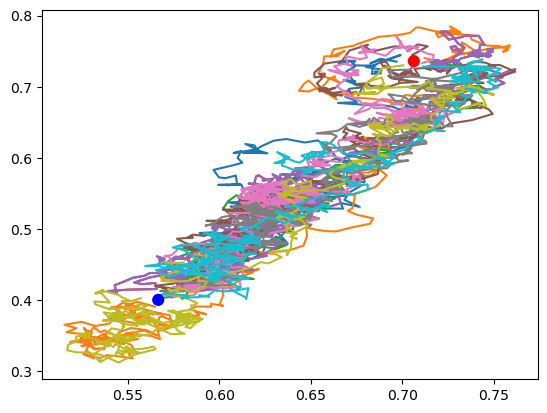

In [51]:
trAB = transitions(stommel_sde, A, B, 10;
    radii=(0.01, 0.01), dt=0.01)

fig, ax = subplots()
ax.scatter([A[1], B[1]], [A[2], B[2]], c=["r", "b"], zorder=99, s=60)
for i in 1:length(trAB.paths)
    ax.plot(trAB.paths[i][:,1], trAB.paths[i][:,2])
end

display(gcf())

In [52]:
instAB = geometric_min_action_method(stommel_sde, A, B, N=200, maxiter=300)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


Minimum action Path of length 200 in 2 dimensions

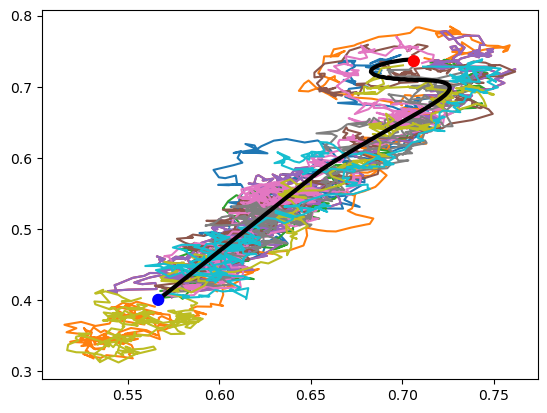

In [53]:
fig, ax = subplots()
ax.scatter([A[1], B[1]], [A[2], B[2]], c=["r", "b"], zorder=99, s=60)
for i in 1:length(trAB.paths)
    ax.plot(trAB.paths[i][:,1], trAB.paths[i][:,2])
end
ax.plot(instAB.path[:,1], instAB.path[:,2], c="k", lw=3)

display(gcf())
